In [153]:
#importing of required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipy_table as tbl
from numbers import Number
from scipy import stats
#allow plots and visualisations to be displayed in the report
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [154]:
# load  data 

titanic_df = pd.read_csv('./AISC1001_Titanic_data_set_pratik_domadiya_500199494.csv')
(titanic_df) # print the whole data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Data Wrangling / Cleaning

In [155]:

# print out information about the data
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


 we can see that the Age, Cabin and Embarked columns are missing entries. As the Cabin column is not relevant to the analysis of the data I will be removing that column however I will need to find a way update populate the missing ages and embarked port.

In [156]:
missing_ages = titanic_df[titanic_df['Age'].isnull()]
# determine mean age based on Sex and Pclass
mean_ages = titanic_df.groupby(['Sex','Pclass'])['Age'].mean()

def remove_na_ages(row):
    '''
    To check if the age is null and replace wth the mean from 
    the mean ages dataframe 
    '''
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'],row['Pclass']]
    else:
        return row['Age']

titanic_df['Age'] =titanic_df.apply(remove_na_ages, axis=1)

In [157]:
#Missing embarkation ports
missing_ports = titanic_df[titanic_df['Embarked'].isnull()]
missing_ports

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [158]:
# For Embarked column we will compute the mode and then replace missing values with it, because it is categorical data 
titanic_df['Embarked'] = titanic_df['Embarked'].replace(np.nan,titanic_df.Embarked.mode()[0])

In [159]:
#Remove un-wanted columns
# dropping columns Cabin, Name and Ticket
titanic_df = titanic_df.drop(['Cabin','Name','Ticket'], axis=1)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [160]:
# now final check for missing data in our dataset
titanic_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In order to intrepret the data easier the following fields need to be modified:

Survived - changed to boolean (1 = True, 0 = False)

Pclass - changed to Socio-Economic status (1st - Upper Class, 2nd - Middle Class, 3rd - Lower Class)

Embarked - changed to name of embarkation port (C = Cherbourg; Q = Queenstown; S = Southampton)

I will also add a Family Size column so that I can compare the size of families with the number of survivors.

In [161]:
def map_data(df):
    '''
    Function which takes the original dataframe and returns a 
    clean / updated dataframe
    '''
    # survived map
    survived_map = {0: False, 1: True}
    df['Survived'] = df['Survived'].map(survived_map)

    # PClass map
    pclass_map = {1: 'Upper Class', 2: 'Middle Class', 3: 'Lower Class'}
    df['Pclass'] = df['Pclass'].map(pclass_map)

    # Embarkation port map
    port_map = {'S': 'Southampton', 'C': 'Cherbourg','Q':'Queenstown'}
    df['Embarked'] = df['Embarked'].map(port_map)
    
    # add new column (FamilySize) to dataframe - sum of SibSp and Parch
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    return df

titanic_df = map_data(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,1,False,Lower Class,male,22.0,1,0,7.2500,Southampton,1
1,2,True,Upper Class,female,38.0,1,0,71.2833,Cherbourg,1
2,3,True,Lower Class,female,26.0,0,0,7.9250,Southampton,0
3,4,True,Upper Class,female,35.0,1,0,53.1000,Southampton,1
4,5,False,Lower Class,male,35.0,0,0,8.0500,Southampton,0


In [162]:
# Grouping / Binning Ages
#To make the ages easier to analyse I thought it would be a good idea to group / bin the ages. 
#This way we can compare groups of ages instead of individual ages.
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
titanic_df['age_group'] = pd.cut(titanic_df.Age, range(0, 81, 10), right=False, labels=age_labels)

In [163]:
titanic_df.head()# data after cleaning task

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,age_group
0,1,False,Lower Class,male,22.0,1,0,7.2500,Southampton,1,20-29
1,2,True,Upper Class,female,38.0,1,0,71.2833,Cherbourg,1,30-39
2,3,True,Lower Class,female,26.0,0,0,7.9250,Southampton,0,20-29
3,4,True,Upper Class,female,35.0,1,0,53.1000,Southampton,1,30-39
4,5,False,Lower Class,male,35.0,0,0,8.0500,Southampton,0,30-39


# Data Analysis ( Hypothesis Testing)

total surviver :  342
total non surviver :  549


c:\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


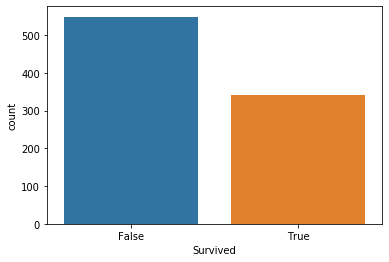

In [164]:
survivors_data = titanic_df[titanic_df.Survived==True]
non_survivors_data = titanic_df[titanic_df.Survived==False]
print("total surviver : ",len(survivors_data))
print("total non surviver : ",len(non_survivors_data))
sns.countplot(titanic_df['Survived'])

# Now we want to check Which gender had a better chance of survival?

Hypothesis

The hypothesis for this question is that the gender does impact the chances of survival

H0 (Null hypothesis )= Gender has no impact on survivability

HA (Alternative Hypothesis ) = Gender does impact the chances of survivabily

Sex       female  male
Survived              
False         81   468
True         233   109

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


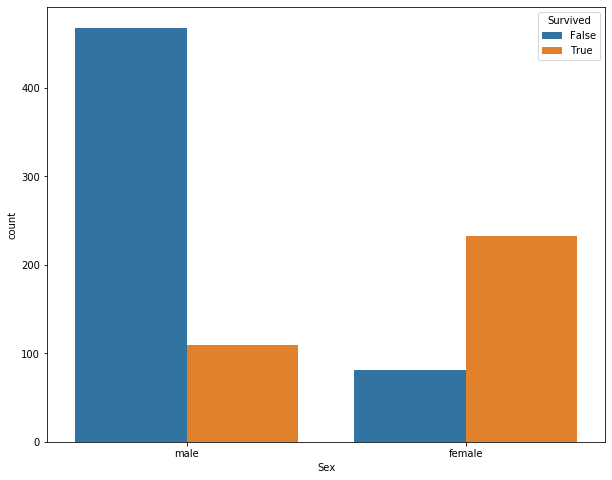

In [165]:
#Count of Survivors by Gender
table = pd.crosstab(titanic_df['Survived'],titanic_df['Sex'])
print (table)
print()
#Proportion of survivors by Gender
print (titanic_df.groupby('Sex').Survived.mean())

plt.figure(figsize=(10,8))
ax = sns.countplot(x='Sex',data=titanic_df,hue="Survived")



Above plots show that there were a significant more males on board the Titanic compared to the number of females. 
Also it shows that Females had a higher proportion of survivors compared to the proportion of males . 
This shows that females had a greater rate of survival.

In [166]:

# we are conducting chi square test here to find out relationship between pasanger_gender and their survival.
'''As the P-Value is less than 0.05 the probability of that the age group will impact the chances of survival is high. 
Therefore I believe that we can reject the null hypothesis.'''

def hypothesis_test(data):
    table = pd.crosstab([titanic_df['Survived']], data)
    chi2, p, dof, expected = stats.chi2_contingency(table.values)
    results = [
        ['Item','Value'],
        ['Chi-Square Test',chi2],
        ['P-Value', p]
    ]
    return results
result=hypothesis_test(titanic_df['Sex'])
# print(result_table)
tbl.make_table(result)

Item,Value
Chi-Square Test,260.7170
P-Value,0.0000


Because the P-Value is less than 0.05, the likelihood that gender will influence survival is high.
As a result, I believe we can reject out the null hypothesis. The plots above, I believe, also support this conclusion.

# Now we can check which Passenger class had a better chance of survival?
Hypothesis

The hypothesis for this question is that the passenger class does impact the chances of survival

H0 (Null Hypothesis) = Passenger Class has no impact on survivability

HA (Alternative Hypothesis) = Passenger Class does impact the chances of survivabily

In [167]:
table = pd.crosstab(titanic_df['Survived'],titanic_df['Pclass'])
print (table)

Pclass    Lower Class  Middle Class  Upper Class
Survived                                        
False             372            97           80
True              119            87          136


'\nThe graphs below show that whilst the lower class had more passengers, than all classes, and more survivors than the middle \nclass, the lower class had the lowest survival rate. The Upper Class passengers had the highest survival rate.\n'

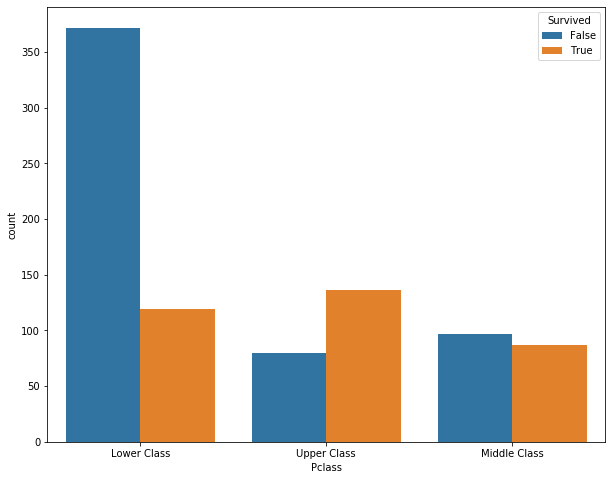

In [168]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='Pclass',data=titanic_df,hue="Survived")
'''
The graphs below show that whilst the lower class had more passengers, than all classes, and more survivors than the middle 
class, the lower class had the lowest survival rate. The Upper Class passengers had the highest survival rate.
'''

In [169]:
#perform hypothesis test on passanger class
result=hypothesis_test(titanic_df['Pclass'])
# print(result_table)
tbl.make_table(result)

Item,Value
Chi-Square Test,102.8890
P-Value,0.0000


Because the P-Value is less than 0.05, the likelihood that Passanger Class will have an impact on survival is high. As a result, I believe we can reject out the null hypothesis. The plot above, I believe, also support the claim.

# Now we want to check which age group had a better chance of survival?

Hypothesis

The hypothesis for this question is that the age group does impact the chances of survival

H0 = Age Group has no impact on survivability

HA = Age Group does impact the chances of survivabily

Text(0.5, 0, 'Age Group')

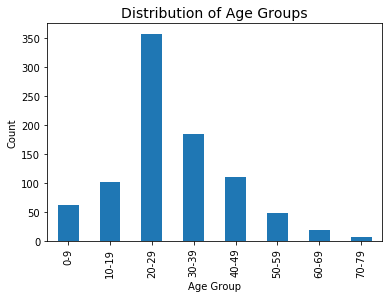

In [170]:
titanic_df.groupby(['age_group']).size().plot(kind='bar',stacked=True)
plt.title("Distribution of Age Groups",fontsize=14)
plt.ylabel('Count')
plt.xlabel('Age Group')

the majority of passengers were aged between 20-29

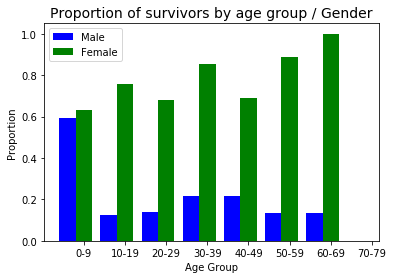

In [171]:
male_data = titanic_df[titanic_df.Sex == "male"].groupby('age_group').Survived.mean().values
female_data = titanic_df[titanic_df.Sex == "female"].groupby('age_group').Survived.mean().values
ax = plt.subplot()
male_plt_position = np.array(range(len(age_labels)))
female_plt_position = np.array(range(len(age_labels)))+0.4
ax.bar(male_plt_position, male_data,width=0.4,label='Male',color='b')
ax.bar(female_plt_position, female_data,width=0.4,label='Female',color='g')


tick_spacing = np.array(range(len(age_labels)))+0.4
plt.xticks(tick_spacing,  age_labels)
ax.set_ylabel("Proportion")
ax.set_xlabel("Age Group")
ax.set_title("Proportion of survivors by age group / Gender",fontsize=14)
plt.legend(loc='best')
plt.show()

 It shows that children (0-9 years old, male and female) and women (all ages) had a much higher proportion of survivors.

In [128]:

#perform hypothesis test on passanger age_group
result=hypothesis_test(titanic_df['age_group'])
# print(result_table)
tbl.make_table(result)

Item,Value
Chi-Square Test,29.5389
P-Value,0.0001



As the P-Value is less than 0.05 the probability of that the age group will impact the chances of survival is high. Therefore I believe that we can reject the null hypothesis.

# modelling 

In [129]:
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,age_group
0,1,False,Lower Class,male,22.0,1,0,7.2500,Southampton,1,20-29
1,2,True,Upper Class,female,38.0,1,0,71.2833,Cherbourg,1,30-39
2,3,True,Lower Class,female,26.0,0,0,7.9250,Southampton,0,20-29
3,4,True,Upper Class,female,35.0,1,0,53.1000,Southampton,1,30-39
4,5,False,Lower Class,male,35.0,0,0,8.0500,Southampton,0,30-39


In [130]:
titanic_df.drop(columns=['PassengerId','SibSp','Parch','age_group',],inplace=True)

In [131]:
titanic_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,False,Lower Class,male,22.0,7.2500,Southampton,1
1,True,Upper Class,female,38.0,71.2833,Cherbourg,1
2,True,Lower Class,female,26.0,7.9250,Southampton,0
3,True,Upper Class,female,35.0,53.1000,Southampton,1
4,False,Lower Class,male,35.0,8.0500,Southampton,0


In [132]:
survived_map = {False :0, True:1}
titanic_df['Survived'] = titanic_df['Survived'].map(survived_map)

# PClass map
pclass_map = { 'Upper Class':1, 'Middle Class':2, 'Lower Class':3}
titanic_df['Pclass'] = titanic_df['Pclass'].map(pclass_map)



In [133]:
# perform standard scaler on numeric data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
titanic_df[['Age', 'Fare']]= scaler.fit_transform(titanic_df[['Age', 'Fare']])
titanic_df.head()
# Creating a dummy variable for some of the categorical variables
dummy_cat = pd.get_dummies(titanic_df[['Sex','Embarked']])
# Adding the results to the main dataframe
titanic_df = pd.concat([titanic_df, dummy_cat], axis=1)
titanic_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Sex_female,Sex_male,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,0,3,male,-0.551366,-0.502445,Southampton,1,0,1,0,0,1
1,1,1,female,0.654030,0.786845,Cherbourg,1,1,0,1,0,0
2,1,3,female,-0.250017,-0.488854,Southampton,0,1,0,0,0,1
3,1,1,female,0.428018,0.420730,Southampton,1,1,0,0,0,1
4,0,3,male,0.428018,-0.486337,Southampton,0,0,1,0,0,1


In [134]:
titanic_df.drop(columns=['Sex','Embarked'],inplace=True)

In [135]:
titanic_df.head()

,Survived,Pclass,Age,Fare,FamilySize,Sex_female,Sex_male,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,0,3,-0.551366,-0.502445,1,0,1,0,0,1
1,1,1,0.654030,0.786845,1,1,0,1,0,0
2,1,3,-0.250017,-0.488854,0,1,0,0,0,1
3,1,1,0.428018,0.420730,1,1,0,0,0,1
4,0,3,0.428018,-0.486337,0,0,1,0,0,1


In [136]:
 # split the data for train and test
X = titanic_df.iloc[:,1:]
print(X)
y = titanic_df['Survived']
print(y)

     Pclass       Age      Fare  FamilySize  Sex_female  Sex_male  \
0         3 -0.551366 -0.502445           1           0         1   
1         1  0.654030  0.786845           1           1         0   
2         3 -0.250017 -0.488854           0           1         0   
3         1  0.428018  0.420730           1           1         0   
4         3  0.428018 -0.486337           0           0         1   
..      ...       ...       ...         ...         ...       ...   
886       2 -0.174680 -0.386671           0           0         1   
887       1 -0.777378 -0.044381           0           1         0   
888       3 -0.570201 -0.176263           3           1         0   
889       1 -0.250017 -0.044381           0           0         1   
890       3  0.202006 -0.492378           0           0         1   

     Embarked_Cherbourg  Embarked_Queenstown  Embarked_Southampton  
0                     0                    0                     1  
1                     1          

In [151]:
# prepare the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_tr_array = X_train
X_ts_array = X_test
y_tr_array = y_train.values
y_ts_array = y_test.values

print('Input train data Shape', (X_tr_array.shape))
print('Output train data Shape', y_tr_array.shape)
print('Input test data Shape', (X_ts_array.shape))
print('Output test data Shape', y_ts_array.shape)

Input train data Shape (712, 9)
Output train data Shape (712,)
Input test data Shape (179, 9)
Output test data Shape (179,)


# Logistic regression model

In [138]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_tr_array, y_tr_array)

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [141]:
pred = log_model.predict(X_ts_array)# make a prediction of the data

In [142]:
print ('Accuracy from sk-learn: {0}'.format(log_model.score(X_ts_array, y_ts_array)))# display accuracy of the model

Accuracy from sk-learn: 0.8156424581005587


Text(0.5, 1, 'Accuracy Score: 0.8156424581005587')

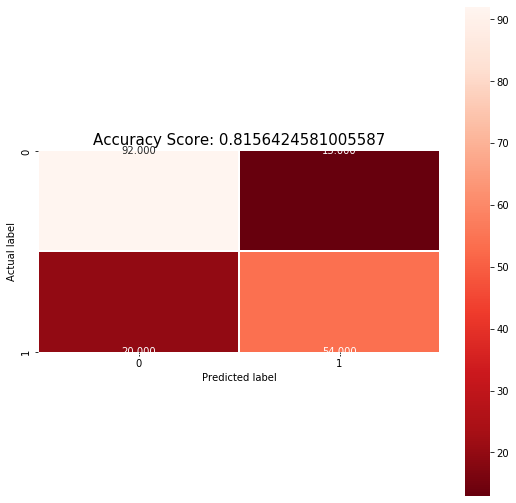

In [143]:
# print confusion metrics
from sklearn import metrics
confusion_matrix=metrics.confusion_matrix(y_ts_array,pred)
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(log_model.score(X_ts_array, y_ts_array))
plt.title(all_sample_title, size = 15)

In [144]:
# display model metrics 
print ('F1 score:', metrics.f1_score(y_ts_array,pred,average='weighted'))# display f1_score 

print ('Recall:', metrics.recall_score(y_ts_array,pred,average='weighted'))# display recall 

print ('Precision:', metrics.precision_score(y_ts_array,pred,average='weighted'))# display precision

print ('\n clasification report:\n', metrics.classification_report(y_ts_array,pred))# display classification report.

F1 score: 0.8140397158008151
Recall: 0.8156424581005587
Precision: 0.8150379387976319

 clasification report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



# DecisionTree classifier 

In [145]:
from sklearn.tree import DecisionTreeClassifier
dc_model=DecisionTreeClassifier(criterion = 'entropy',random_state=42)
dc_model.fit(X_tr_array,y_tr_array)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [146]:
pred = dc_model.predict(X_ts_array)# make a prediction of the data

In [147]:
print ('Accuracy from sk-learn: {0}'.format(dc_model.score(X_ts_array, y_ts_array)))# display accuracy of the model

Accuracy from sk-learn: 0.7821229050279329


Text(0.5, 1, 'Accuracy Score: 0.7821229050279329')

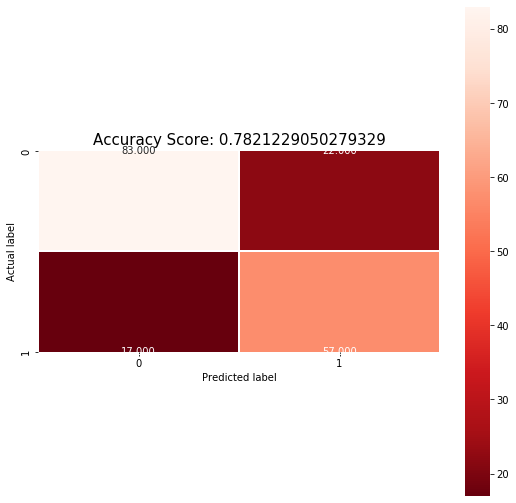

In [148]:
# print confusion metrics
from sklearn import metrics
confusion_matrix=metrics.confusion_matrix(y_ts_array,pred)
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(dc_model.score(X_ts_array, y_ts_array))
plt.title(all_sample_title, size = 15)

In [149]:
# display model metrics 
print ('F1 score:', metrics.f1_score(y_ts_array,pred,average='weighted'))# display f1_score 

print ('Recall:', metrics.recall_score(y_ts_array,pred,average='weighted'))# display recall 

print ('Precision:', metrics.precision_score(y_ts_array,pred,average='weighted'))# display precision

print ('\n clasification report:\n', metrics.classification_report(y_ts_array,pred))# display classification report.

F1 score: 0.7830259505355487
Recall: 0.7821229050279329
Precision: 0.785153100912241

 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       105
           1       0.72      0.77      0.75        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.78      0.78       179

